# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [178]:
#Import all the required libraries
import glob
import seaborn as sns
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings('ignore')

Let's read the dataset

**This needed to be done to solve basic memory issues in my system.**

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6608437188057899339
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1387367424
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1647291994368609447
physical_device_desc: "device: 0, name: NVIDIA GeForce MX350, pci bus id: 0000:06:00.0, compute capability: 6.1"
]


## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [4]:
#Import the dataset and read the image into a seperate variable

images=(r'D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images')

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [5]:
#Visualise both the images & text present in the dataset
def visualise_image(images, caption = None, cmap = None):
    f, axes = plt.subplots(1, len(images))
    f.set_figwidth(20)
    f = plt.figure(figsize=(7, 5))
    
    for ax, image in zip(axes, images):
        ax.imshow(io.imread(image), cmap)

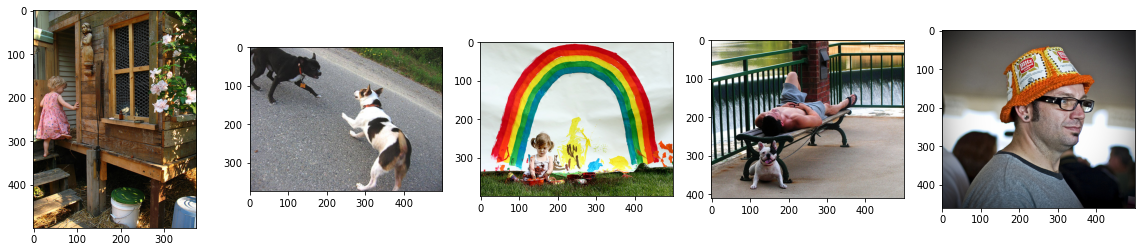

<Figure size 504x360 with 0 Axes>

In [6]:
visualise_image(all_imgs[:5])

In [7]:
#Import the dataset and read the text file into a seperate variable
text_file=(r"D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\captions.txt")
def load_doc(filename):
    
    file=open(filename)
    text=file.read()
    file.close()
    
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [8]:
#caption_df=pd.read_csv(text_file)

In [9]:
#all_img_id= #store all the image id here
#all_img_vector= #store all the image path here
#annotations= #store all the captions here

doc1=doc.splitlines()[1:] #This splits the string file before and after each line
all_img_id=[]
annotations=[]
all_img_vector=[]
for i in doc1:
    idx=i.index(",")         ###Setting the "," seperator as the index
    image_id=i[:idx]         ###This will store the values before the "," seperator in each line
    image_caption=i[idx+1:]  ###This will store the values after the "," seperator in each line
    all_img_id.append(image_id)   
    annotations.append(image_caption)
    all_img_vector.append(images+"\\"+ image_id)
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images\1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images\1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images\1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images\1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images\1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
5,1001773457_577c3a7d70.jpg,D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images\1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images\1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
7,1001773457_577c3a7d70.jpg,D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images\1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
8,1001773457_577c3a7d70.jpg,D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images\1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
9,1001773457_577c3a7d70.jpg,D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Images\1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [10]:
df["Captions"].head()

0    A child in a pink dress is climbing up a set o...
1                A girl going into a wooden building .
2     A little girl climbing into a wooden playhouse .
3    A little girl climbing the stairs to her playh...
4    A little girl in a pink dress going into a woo...
Name: Captions, dtype: object

In [11]:
#Create the vocabulary & the counter for the captions
##To use counter we need to seperate each WORD seperately. Hence we would seperate each word 
#and put it in a list.
vocabulary=[]
for i in df["Captions"]:
    vocabulary=vocabulary+i.split(" ")

#vocabulary= #write your code here

val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

In [12]:
#Checking the type of val_count
type(val_count)

collections.Counter

In [13]:
#Visualise the top 30 occuring words in the captions
df1=pd.DataFrame.from_dict(val_count,orient="index")
df1=df1.sort_values(by=[0],ascending=False)
df1=df1.reset_index()
df1.columns=["Words","Count"]
df1=df1.head(30)

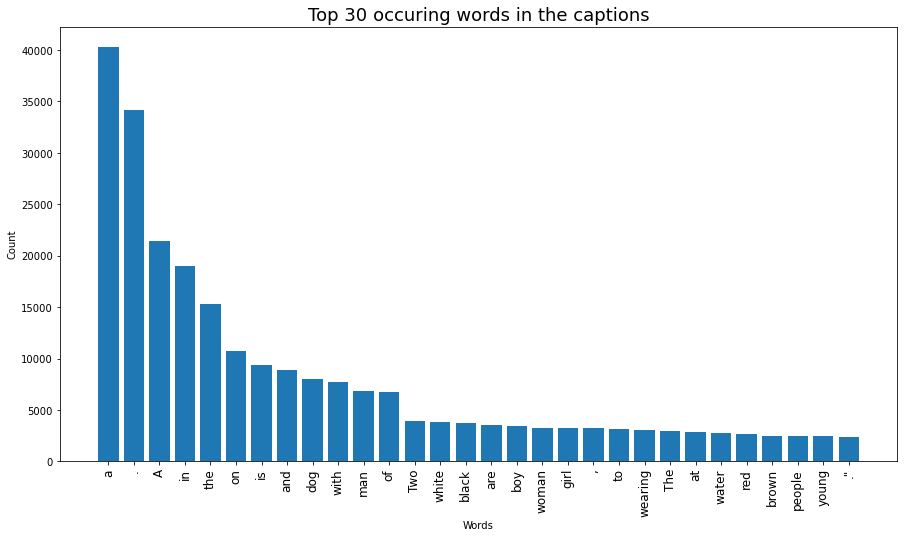

In [14]:
plt.figure(figsize=(15,8))
plt.title("Top 30 occuring words in the captions",fontsize=18)
plt.bar(df1["Words"],height=df1["Count"])
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(df1["Words"],rotation=90,fontsize=12)
plt.show()


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [15]:
#help(tf.keras.preprocessing.text.Tokenizer)

In [16]:
#Creating start and end token after and before each caption
annotations = df.Captions.apply(lambda x:"<start>"+" "+x+" "+"<end>") #add the <start> & <end> token to all those captions as well

print(str(len(annotations)))

40455


In [17]:
print(annotations[:10])

0    <start> A child in a pink dress is climbing up...
1    <start> A girl going into a wooden building . ...
2    <start> A little girl climbing into a wooden p...
3    <start> A little girl climbing the stairs to h...
4    <start> A little girl in a pink dress going in...
5    <start> A black dog and a spotted dog are figh...
6    <start> A black dog and a tri-colored dog play...
7    <start> A black dog and a white dog with brown...
8    <start> Two dogs of different breeds looking a...
9    <start> Two dogs on pavement moving toward eac...
Name: Captions, dtype: object


**This shows that we have succesfully added the start and the end tokens.**

In [18]:
# create the tokenizer
#your code here
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=5000,oov_token="<unk>",
                                                filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)

In [19]:
# Create word-to-index and index-to-word mappings.

#your code here
pad_token="<pad>"
tokenizer.word_index[pad_token] = 0
tokenizer.index_word[0] = pad_token

In [20]:
word_counts=tokenizer.word_counts
word_counts

OrderedDict([('start', 40464),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('end', 40507),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('colored',

In [21]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
df_word_count=pd.DataFrame.from_dict(word_counts,orient="index")
df_word_count=df_word_count.sort_values(by=[0],ascending=False)
df_word_count=df_word_count.reset_index()
df_word_count.columns=["Words","Count"]
df_word_count=df_word_count.head(30)

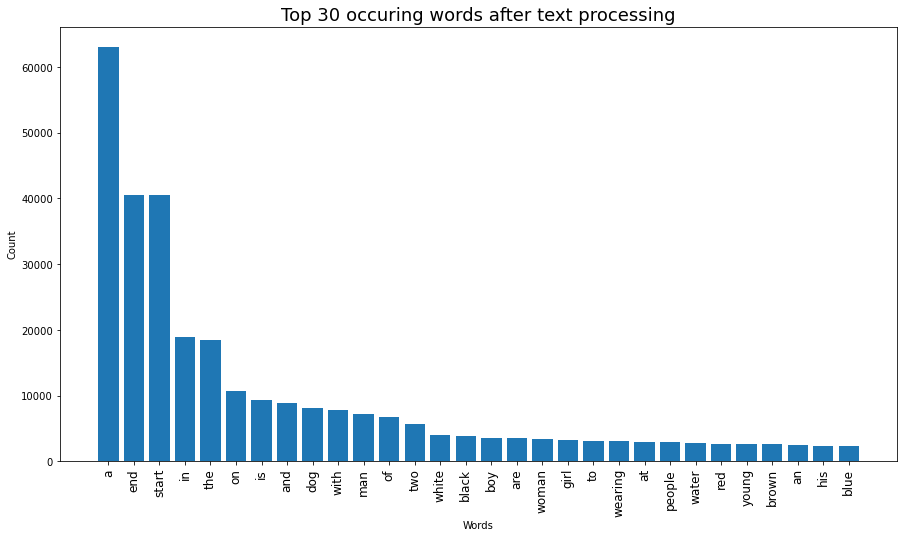

In [22]:
plt.figure(figsize=(15,8))
plt.title("Top 30 occuring words after text processing",fontsize=18)
plt.bar(df_word_count["Words"],height=df_word_count["Count"])
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(df_word_count["Words"],rotation=90,fontsize=12)
plt.show()

In [23]:
#Creating the tokenized vector
text_sequence = tokenizer.texts_to_sequences(annotations)

In [24]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
max_length= max(len(t) for t in text_sequence)

#Here post padding would be apprpriate which means adding zeroes at the end of the sequence
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(text_sequence, padding='post',maxlen=max_length)


print(cap_vector.shape)

(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [25]:
#write your code here to create the dataset consisting of image paths

## Since the image path will have duplicates we will use it as a set to get rid of duplicates
## Since tf.data.Dataset.from_tensor_slices doesn't accept set, we use sorted to convert it into list.
new_path_file=sorted(set(all_img_vector))
dataset=tf.data.Dataset.from_tensor_slices(new_path_file)
dataset

<TensorSliceDataset shapes: (), types: tf.string>

**This dataset may look empty seeing the shape but when we iterate, we see that it has values.**

In [26]:
##Iterating through the dataset
for i in dataset:
    print(i)

tf.Tensor(b'D:\\Upgrad Data Science PGDDS\\Course 5 Capstone Project\\Images\\1000268201_693b08cb0e.jpg', shape=(), dtype=string)
tf.Tensor(b'D:\\Upgrad Data Science PGDDS\\Course 5 Capstone Project\\Images\\1001773457_577c3a7d70.jpg', shape=(), dtype=string)
tf.Tensor(b'D:\\Upgrad Data Science PGDDS\\Course 5 Capstone Project\\Images\\1002674143_1b742ab4b8.jpg', shape=(), dtype=string)
tf.Tensor(b'D:\\Upgrad Data Science PGDDS\\Course 5 Capstone Project\\Images\\1003163366_44323f5815.jpg', shape=(), dtype=string)
tf.Tensor(b'D:\\Upgrad Data Science PGDDS\\Course 5 Capstone Project\\Images\\1007129816_e794419615.jpg', shape=(), dtype=string)
tf.Tensor(b'D:\\Upgrad Data Science PGDDS\\Course 5 Capstone Project\\Images\\1007320043_627395c3d8.jpg', shape=(), dtype=string)
tf.Tensor(b'D:\\Upgrad Data Science PGDDS\\Course 5 Capstone Project\\Images\\1009434119_febe49276a.jpg', shape=(), dtype=string)
tf.Tensor(b'D:\\Upgrad Data Science PGDDS\\Course 5 Capstone Project\\Images\\1012212859_0

In [27]:
#write your code here for creating the function. This function should return images & their path

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,(299,299))
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    
    return  image, image_path

In [28]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path

dataset=dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)
dataset


<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [29]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output ##Here -1 is used because we need the last layer output

image_features_extract_model = keras.Model(new_input,hidden_layer)

In [30]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
features_dict={}
for image,path in tqdm(dataset):
    features = image_features_extract_model(image)
    features = tf.reshape(features,(features.shape[0], -1, features.shape[3]))
    for feat, p in zip(features, path):
        feat_path = p.numpy().decode("utf-8") ##This decoding is done because the values are not in ASCII
        features_dict[feat_path] =  feat.numpy() ##This will convert the tensor instance to numpy

100%|████████████████████████████████████████████████████████████████████████████████| 253/253 [03:22<00:00,  1.25it/s]


**The dictionary has to be saved while reshaping the features otherwise there will be a key error.**

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [31]:
#write your code here

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,
                                                              train_size=0.8,random_state=42 )

In [32]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [33]:
# Create a function which maps the image path to their feature. 
# This function will take the image_path & caption and return it's feature & respective caption.
        
def map_func(image_path,caption):
    img_tensor = features_dict[image_path.decode('utf-8')] #Since the source text is in UTF-8 format
    return img_tensor,caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [34]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

def gen_dataset(img_path1,captions):
    dataset1=tf.data.Dataset.from_tensor_slices((img_path1,captions))
    dataset1=dataset1.shuffle(1000,reshuffle_each_iteration=True)
    dataset1=dataset1.map(lambda x,y:tf.numpy_function(map_func,[x,y],[tf.float32,tf.int32])).batch(32)
    dataset1=dataset1.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset1

In [35]:
train_dataset=gen_dataset(path_train,cap_train)
test_dataset=gen_dataset(path_test,cap_test)

In [36]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

**Batch size of 64 is giving me memory exhausted error. Hence would go with 32.**

### Set the parameters

In [37]:
embedding_dim = 256 
units = 512
BATCH_SIZE=32
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

### Build the Encoder, Attention model & Decoder

#### Encoder

In [38]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features =  self.dense(features)
        features = tf.nn.relu(features)
        
        return features

In [39]:
encoder=Encoder(embedding_dim)

#### Attention model

In [40]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden,1)
        score = self.V(tf.nn.tanh(self.W1(features) +self.W2(hidden_with_time_axis)))
        attention_weights =  tf.nn.softmax(score, axis=1)
        context_vector =  attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1) #To squeeze the output to a smaller
                                                               #dimension
        
        return context_vector, attention_weights

#### Decoder

In [41]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        embed =  self.embed(x)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        output,state = self.gru(embed)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) 
        output = self.d2(output)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [42]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [43]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['start']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

### Set the optimizer & loss object

In [44]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [45]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    

    return tf.reduce_mean(loss_)

### Create your checkpoint path

In [46]:
checkpoint_path = (r"D:\Upgrad Data Science PGDDS\Course 5 Capstone Project\Checkpoint\Train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [47]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

### Create your training & testing step functions

In [48]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['start']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [49]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['start']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss / int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))        
    return loss, avg_loss

### Create your loss function for the test dataset

In [50]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [53]:
#Importing the required packages
import time
loss_plot=[]
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.443, & test loss is 0.480
Time taken for 1 epoch 487.5319011211395 sec

Test loss has been reduced from 100.000 to 0.480


  7%|█████▎                                                                          | 1/15 [08:08<1:53:59, 488.51s/it]

For epoch: 2, the train loss is 0.431, & test loss is 0.450
Time taken for 1 epoch 584.8366904258728 sec

Test loss has been reduced from 0.480 to 0.450


 13%|██████████▋                                                                     | 2/15 [17:54<1:58:15, 545.81s/it]

For epoch: 3, the train loss is 0.416, & test loss is 0.431
Time taken for 1 epoch 543.7881486415863 sec

Test loss has been reduced from 0.450 to 0.431


 20%|████████████████                                                                | 3/15 [26:59<1:49:04, 545.41s/it]

For epoch: 4, the train loss is 0.403, & test loss is 0.414
Time taken for 1 epoch 544.9920864105225 sec

Test loss has been reduced from 0.431 to 0.414


 27%|█████████████████████▎                                                          | 4/15 [36:05<1:40:01, 545.60s/it]

For epoch: 5, the train loss is 0.389, & test loss is 0.401
Time taken for 1 epoch 505.0679979324341 sec

Test loss has been reduced from 0.414 to 0.401


 33%|██████████████████████████▋                                                     | 5/15 [44:31<1:28:33, 531.38s/it]

For epoch: 6, the train loss is 0.378, & test loss is 0.387
Time taken for 1 epoch 585.1357061862946 sec

Test loss has been reduced from 0.401 to 0.387


 40%|████████████████████████████████                                                | 6/15 [54:17<1:22:30, 550.01s/it]

For epoch: 7, the train loss is 0.369, & test loss is 0.376
Time taken for 1 epoch 625.8481206893921 sec

Test loss has been reduced from 0.387 to 0.376


 47%|████████████████████████████████████▍                                         | 7/15 [1:04:44<1:16:42, 575.26s/it]

For epoch: 8, the train loss is 0.359, & test loss is 0.366
Time taken for 1 epoch 645.0592279434204 sec

Test loss has been reduced from 0.376 to 0.366


 53%|█████████████████████████████████████████▌                                    | 8/15 [1:15:31<1:09:44, 597.85s/it]

For epoch: 9, the train loss is 0.349, & test loss is 0.359
Time taken for 1 epoch 631.1664175987244 sec

Test loss has been reduced from 0.366 to 0.359


 60%|██████████████████████████████████████████████▊                               | 9/15 [1:26:03<1:00:51, 608.62s/it]

For epoch: 10, the train loss is 0.341, & test loss is 0.347
Time taken for 1 epoch 616.5195510387421 sec

Test loss has been reduced from 0.359 to 0.347


 67%|████████████████████████████████████████████████████▋                          | 10/15 [1:36:21<50:57, 611.41s/it]

For epoch: 11, the train loss is 0.332, & test loss is 0.341
Time taken for 1 epoch 615.4857995510101 sec

Test loss has been reduced from 0.347 to 0.341


 73%|█████████████████████████████████████████████████████████▉                     | 11/15 [1:46:37<40:52, 613.02s/it]

For epoch: 12, the train loss is 0.325, & test loss is 0.333
Time taken for 1 epoch 611.1800332069397 sec

Test loss has been reduced from 0.341 to 0.333


 80%|███████████████████████████████████████████████████████████████▏               | 12/15 [1:56:50<30:38, 612.84s/it]

For epoch: 13, the train loss is 0.317, & test loss is 0.329
Time taken for 1 epoch 585.0238642692566 sec

Test loss has been reduced from 0.333 to 0.329


 87%|████████████████████████████████████████████████████████████████████▍          | 13/15 [2:06:36<20:09, 604.78s/it]

For epoch: 14, the train loss is 0.311, & test loss is 0.316
Time taken for 1 epoch 544.367856502533 sec

Test loss has been reduced from 0.329 to 0.316


 93%|█████████████████████████████████████████████████████████████████████████▋     | 14/15 [2:15:41<09:46, 586.88s/it]

For epoch: 15, the train loss is 0.307, & test loss is 0.310
Time taken for 1 epoch 506.60499811172485 sec

Test loss has been reduced from 0.316 to 0.310


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [2:24:09<00:00, 576.64s/it]


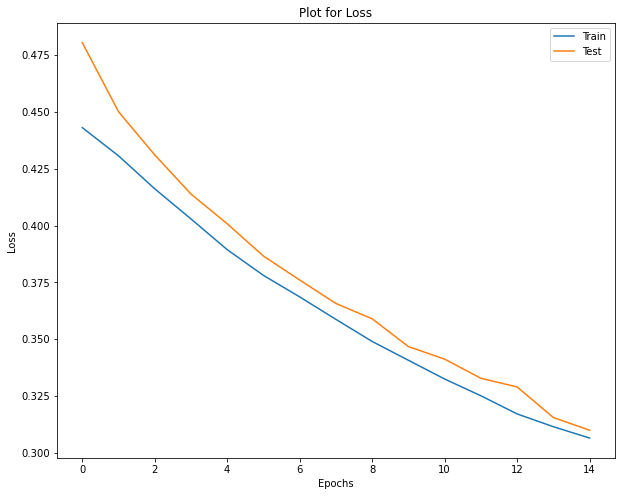

In [179]:
plt.figure(figsize=[10,8])
plt.title('Plot for Loss')
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(["Train","Test"],loc="best")
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [77]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =tf.random.categorical(predictions, 1)[0][0].numpy() #the format needs to be in numpy
        result.append(tokenizer.index_word[predicted_id])


        if tokenizer.index_word[predicted_id] == 'end':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

**Commenting this block of code since this is optional.**

In [ ]:
#def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
    #return final_caption


In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [87]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [88]:
features_shape = feat.shape[1]
attention_features_shape = feat.shape[0]

BELU score: 69.62672436533984
Real Caption: start a woman doing a jump on a bike end
Prediction Caption: a guy on a bike doing a trick above the water


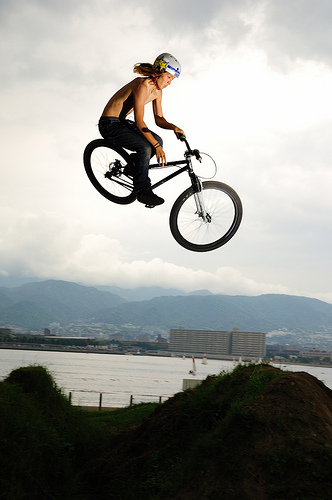

In [114]:
rid = np.random.randint(0, len(path_test))
test_image = path_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(0.2,0.2,0,0))
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)


Image.open(test_image)

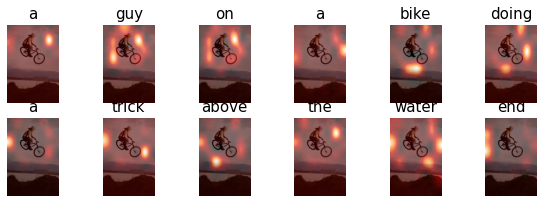

In [116]:
plot_attmap(result, attention_plot, test_image)

**Inferences observed:**
1. The BLEU Score is almost 70 which is a really nice BLEU Score. This goes to say that the translation is near to perfect.
2. The predicted caption is very much simiiar to the actual caption. 

## Converting the caption to audio using Google Text-to-Speech(gTTS) API

In [174]:
from gtts import gTTS
from IPython import display
from IPython.display import Audio 
from playsound import playsound

tts = gTTS(pred_caption, slow = False)
tts.save('pred_caption1.mp3')

playsound(r'C:\Users\deabh\pred_caption1.mp3')

In [177]:
Audio(r'C:\Users\deabh\pred_caption1.mp3',autoplay=True)

**Commenting this block of code since this is optional.**

In [118]:
#captions=beam_evaluate(test_image)
#print(captions)